# BDI Python Code Clinic 29th April
## Collecting disparate data online by web scraping using Selenium and BeautifulSoup

Ideally the data we wish to work on can be downloaded in an easy to use format. Otherwise when we want only a small subset of a very big dataset, or the data is being constantly updated, hopefully the owner will provide an application programming interface (API) to automate the collection of the relevant data. However quite often the data cannot be downloaded and there is no API, but the data is publicly available, just dispersed across a website. When it would be too tedious and time consuming to navigate page by page to collect the data manually; we can use Selenium Webdriver and Beautiful Soup to automate navigating across the website and collecting of the relevant data. In this code clinic, I will go through the best practices (and what not to do!) when web scraping; using Selenium Webdriver to navigate around a website and then using Beautiful Soup to extract the data from the HTML.


### Section 0: Load the packages and open a remote controlled browser

In [1]:
# Import the necessary packages
from selenium import webdriver
import requests

In [3]:
# Fire up Selenium webdriver with the website we want to scrape
browser = webdriver.Firefox() # If you use a different browser, replace Firefox with this
base_url = "https://www.literaryclock.com/"
browser.get(base_url)

# # Alternatively, use requests
# requests.get(base_url, timeout=1) # Hopefully get Response [200], not [404]

<Response [200]>

### Section 1: Navigating around using selenium

#### 1.1: Using link text

In [4]:
# Start navigating around
element = browser.find_element_by_link_text("Posts")
print(element)

<selenium.webdriver.firefox.webelement.FirefoxWebElement (session="69c3489c-1a3a-214f-90b3-509039a4d063", element="70fd1970-e570-9d4b-be34-57ef910653af")>


In [5]:
element.click()

#### 1.2: How to submit text, and limitations of being a robot

In [6]:
# Go to text, play around with inputing text
browser.find_element_by_link_text("Contact").click()

In [7]:
# Need to find the boxes to input text
element = browser.find_element_by_css_selector('input[id="name"]')
print(element)

<selenium.webdriver.firefox.webelement.FirefoxWebElement (session="69c3489c-1a3a-214f-90b3-509039a4d063", element="4c37016b-9077-6a43-beae-5ba007dfb8c2")>


In [8]:
element.send_keys('Justin')

In [9]:
# Similarly can you put text in the subject line
browser.find_element_by_css_selector('input[id="subject"]').send_keys('Hello!')

In [10]:
# Slightly different challenge in inputing data into the message box
# Message is not an 'input', it is a textarea
browser.find_element_by_css_selector('textarea[id="message"]').send_keys('How are you doing?')

In [ ]:
# Can we automatically pretend not to be a robot, probably not.

In [11]:
# Now how do we click on the send button
browser.find_element_by_css_selector('input[id="submit"]').click()

### Section 2: Webscraping time

#### 2.1 Can we get a the literary works, their authors and their date

In [12]:
# Navigate to Posts
browser.find_element_by_link_text("Posts").click()

In [13]:
# And now The Literary Clock Library
browser.find_element_by_link_text("The Literary Clock Library").click()

ElementNotInteractableException: Message: Element <a href="/posts/Lt5_Library"> could not be scrolled into view


In [14]:
# Use javascript to click on the element instead
element = browser.find_element_by_link_text("The Literary Clock Library")
browser.execute_script("arguments[0].click();", element)

In [16]:
# And now to the 1500s
browser.find_element_by_link_text("1500s").click()

In [27]:
# Can we grab the plays first performed in the 1500s
from bs4 import BeautifulSoup
from time import sleep

html_source = browser.page_source
soup = BeautifulSoup(html_source, 'html.parser')

# # Alternative with requests
# html = requests.get(base_url+'library/1500', timeout=1)
# soup = BeautifulSoup(html.text, 'html.parser')

In [28]:
# Looking at the 'li' tag
print(soup.li)

<li><a href="/">Home</a></li>


In [29]:
# OK, get all the 'li' tags
print(soup.findAll('li'))

[<li><a href="/">Home</a></li>, <li><a href="/posts/">Posts</a></li>, <li><a href="/contact">Contact</a></li>, <li>1591: King Richard III by William Shakespeare</li>, <li>1599: As You Like It by William Shakespeare</li>]


In [30]:
# Look to see if it is a link or not
for i in soup.findAll('li'):
    print(i.a)
    

<a href="/">Home</a>
<a href="/posts/">Posts</a>
<a href="/contact">Contact</a>
None
None


In [31]:
# So we can filter out by link (and we can also look at the link)
for i in soup.findAll('li'):
    if i.a != None:
        print(i.a['href'])

/
/posts/
/contact


In [32]:
books = {}
counter = 0
for i in soup.findAll('li'):
    if i.a == None:
        books[counter] = {}
        
        book = i.string
        
        books[counter]['Year'] = int(book[:4])
        
        temp = book[6:].split(' by ')
        
        books[counter]['Title'] = temp[0]
        books[counter]['Author'] = temp[1]
        
        counter +=1

In [35]:
# Can now look at this in a dataframe
import pandas as pd
df = pd.DataFrame(books).T
print(df)

   Year                                   Title               Author
0  1591                        King Richard III  William Shakespeare
1  1599                          As You Like It  William Shakespeare
2  1603                                  Hamlet  William Shakespeare
3  1623                                 Macbeth  William Shakespeare
4  1669  The Diary of Samuel Pepys: A Selection         Samuel Pepys


In [34]:
# OK, lets add the 1600s
browser.find_element_by_partial_link_text("Next").click() # Nice alternative to find_element_by_link_text

html_source = browser.page_source
soup = BeautifulSoup(html_source, 'html.parser')

# Now put all of the books from this page into the "books" dictionary
for i in soup.findAll('li'):
    if i.a == None:
        books[counter] = {}
        
        book = i.string
        
        books[counter]['Year'] = int(book[:4])
        
        temp = book[6:].split(' by ')
        
        books[counter]['Title'] = temp[0]
        books[counter]['Author'] = temp[1]
        
        counter +=1

#### 2.2 Automatically get all the literary works, their authors and their date

In [36]:
# OK let's go back to the 1500s and try get them all
from time import sleep
browser.find_element_by_partial_link_text("Prev").click()

carry_on = True
books = {}
counter = 0
while carry_on:
    html_source = browser.page_source
    soup = BeautifulSoup(html_source, 'html.parser')
    
    for i in soup.findAll('li'):
        if i.a == None:
            books[counter] = {}
        
            book = i.string
            # print(book)
        
            books[counter]['Year'] = int(book[:4])
        
            temp = book[6:].split(' by ')
        
            books[counter]['Title'] = temp[0]
            books[counter]['Author'] = temp[1]
        
            counter +=1
            
    try:
        browser.find_element_by_partial_link_text("Next").click()
        sleep(2)
    except:
        carry_on=False

IndexError: list index out of range

In [37]:
df = pd.DataFrame(books).T
print(df)

   Year                                              Title  \
0  1591                                   King Richard III   
1  1599                                     As You Like It   
2  1603                                             Hamlet   
3  1623                                            Macbeth   
4  1669             The Diary of Samuel Pepys: A Selection   
5  1759  The Life and Opinions of Tristram Shandy, Gent...   
6  1790                               Mutiny on the Bounty   
7  1798                    The Rime of the Ancient Mariner   
8  1800                                             o 1850   

                    Author  
0      William Shakespeare  
1      William Shakespeare  
2      William Shakespeare  
3      William Shakespeare  
4             Samuel Pepys  
5          Laurence Sterne  
6            William Bligh  
7  Samuel Taylor Coleridge  
8                      NaN  


In [38]:
books = {}
counter = 0
for century in ['/1500', '/1600', '/1700']:
    browser.get(base_url + 'library' + century)
    html_source = browser.page_source
    soup = BeautifulSoup(html_source, 'html.parser')
    
#     # Alternative with requests
#     html = requests.get(base_url + 'library' + century, timeout=1)
#     soup = BeautifulSoup(html.text, 'html.parser')
    
    for i in soup.findAll('li'):
        if i.a == None:
            books[counter] = {}

            book = i.string
            # print(book)

            books[counter]['Year'] = int(book[:4])

            temp = book[6:].split(' by ')

            books[counter]['Title'] = temp[0]
            books[counter]['Author'] = temp[1]

            counter +=1
    
    sleep(2)

df = pd.DataFrame(books).T
print(df)

   Year                                              Title  \
0  1591                                   King Richard III   
1  1599                                     As You Like It   
2  1603                                             Hamlet   
3  1623                                            Macbeth   
4  1669             The Diary of Samuel Pepys: A Selection   
5  1759  The Life and Opinions of Tristram Shandy, Gent...   
6  1790                               Mutiny on the Bounty   
7  1798                    The Rime of the Ancient Mariner   

                    Author  
0      William Shakespeare  
1      William Shakespeare  
2      William Shakespeare  
3      William Shakespeare  
4             Samuel Pepys  
5          Laurence Sterne  
6            William Bligh  
7  Samuel Taylor Coleridge  


In [39]:
# Now for the 1800s, 1900s and 2000s
for century in ['/1800', '/1900', '/2000']:
    browser.get(base_url + 'library' + century)
    html_source = browser.page_source
    soup = BeautifulSoup(html_source, 'html.parser')
    
#     # Alternative with requests
#     html = requests.get(base_url + 'library' + century, timeout=1)
#     soup = BeautifulSoup(html.text, 'html.parser')
    
    to_do = []
    for i in soup.findAll('a'):
        if '/library' + century in i['href']:
            to_do.append(i['href'])
    
    for period in to_do:
        browser.get(base_url + period)
        html_source = browser.page_source
        soup = BeautifulSoup(html_source, 'html.parser')
        
#         # Alternative with requests
#         html = requests.get(base_url + period, timeout=1)
#         soup = BeautifulSoup(html.text, 'html.parser')
        
        for i in soup.findAll('li'):
            if i.a == None:
                books[counter] = {}

                book = i.string
                # print(book)

                books[counter]['Year'] = int(book[:4])

                temp = book[6:].split(' by ')

                books[counter]['Title'] = temp[0]
                books[counter]['Author'] = temp[1]

                counter +=1
        
        sleep(2)

df = pd.DataFrame(books).T

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122e04710>]],
      dtype=object)

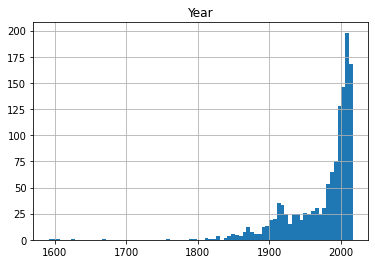

In [41]:
# Look to quickly plot the distribution of years
df['Year'] = df['Year'].astype('int')
df.hist(column='Year', bins=80)